# ROXSI '22 SSA rock circulation
Plot mean water circulation patterns around the small-scale array rock from Vectors/Signatures at specified time periods.

In [54]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')

# Read API key from environment variable
api_key = os.environ["OPENAI_API_KEY"]

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')

# Sig100 serial number to visualize
# Choices: ['103088', '103094', '103110', '103063', '103206']
ser = 103063
veldir = os.path.join(data_root, '{}'.format(ser)) # Velocity netcdf directory
specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory

# Nortek Vector ADVs
data_vec = os.path.join(rootdir, 'Vectors', 'Level1', 'netcdf_old')
fns_vec = sorted(glob.glob(os.path.join(data_vec, '*Vec*.nc')))

# Output figure directory
figdir  = os.path.join(rootdir, 'Vectors', 'Level1', 'img')
if not os.path.isdir(figdir):
    os.mkdir(figdir)


## Mean Vector velocities

In [22]:
def nan50_mean(da):
    return da.mean(dim='time').where(
        # da.notnull().sum(dim='time') >= len(da.time)*0.5
        da.notnull().sum(dim='time') >= 8000
    )

def nan50_std(da):
    return da.std(dim='time').where(
        # da.notnull().sum(dim='time') >= len(da.time)*0.5
        da.notnull().sum(dim='time') >= 8000
    )

t0_min = pd.Timestamp('2022-06-27 00:00:00')
t0_max = pd.Timestamp('2022-07-20 00:00:00')
# Read vector Level1 netcdf file for mooring C3
servs = ['17212', '17219', '17371', '17372', '17376', '17377'] # Serial #s of Vectors
mids = ['C2', 'C3', 'C4', 'C5', 'L2', 'L4'] # Mooring IDs
vecd = {} # Dict to store Vector mean velocity datasets
vecsd = {} # Dict to store Vector std velocity datasets
dfd = {} # Dict to store (downward) zero-crossing dataframes
dfu = {} # Dict to store (upward) zero-crossing dataframes
for mid, serv in zip(mids, servs):
    fn_vec = [f for f in fns_vec if serv in f]
    print('Reading {} ...'.format(os.path.basename(fn_vec[0])))
    dsv = xr.decode_cf(xr.open_dataset(fn_vec[0], decode_coords='all'))
    t_start = pd.Timestamp('2022-06-27 00:00:00')
    t_end = pd.Timestamp('2022-07-20 00:00:00')
    dsv = dsv.sel(time=slice(t_start, t_end))

    # Convert despiked xyz velocities to ENU
    print('Converting velocities ...')
    enu = rpct.uvw2enu(vel=np.array([dsv.uxd.values, dsv.uyd.values, dsv.uzd.values]).T, 
        heading=dsv.heading_ang.values, pitch=dsv.pitch_ang.values,
        roll=dsv.roll_ang.values, magdec=12.86)

    # Save variables to dataset
    dsv['uE'] = (['time'], enu[0,:].copy())
    dsv['uN'] = (['time'], enu[1,:].copy())
    dsv['uU'] = (['time'], enu[2,:].copy())

    # Convert E,N velocities to local cross- & alongshore (x,y) components
    angle_met = 300
    angle_math = 270 - angle_met
    if angle_math < 0:
        angle_math += 360
    angle_math = np.deg2rad(angle_math)
    ur, vr = rpct.rotate_vel(dsv['uE'].values, dsv['uN'].values, angle_math)
    dsv['ucs'] = (['time'], ur)
    dsv['uls'] = (['time'], vr)

    # Initialize lists to store zero-crossing data
    dzc = {'Hw': [], 'Hc':[], 'eta_mean':[], 'ucs_mean':[], 'uls_mean':[], 'w_mean':[]} # DZC
    dzcu = {'Hw': [], 'Hc':[], 'eta_mean':[], 'ucs_mean':[], 'uls_mean':[], 'w_mean':[]} # UZC
    timestamps_d = []
    timestamps_u = []
    # Estimate spectra from bursts
    spec_range = pd.date_range(t_start, t_end, freq='1H')
    # Iterate over bursts
    for t0 in spec_range:
        if t0 <= t0_min:
            continue
        if t0 >= t0_max:
            continue
        # Take out segment
        t1 = t0 + pd.Timedelta(hours=1)
        spec_cols = ['ucs', 'uls', 'uU', 'eta_lin', 'eta_hyd']
        seg = dsv[spec_cols].sel(time=slice(t0, t1)).copy()
        # Get zero crossings from linear surface reconstruction
        eta = seg.eta_lin.to_dataframe() # Convert to pandas
        # Remove leading/trailing NANs
        eta = eta.dropna()
        eta = eta.iloc[30*16:-30*16]
        zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='down', minlen=4*16)
        # Get mean waterlevel for each wave
        _, eta_mean = rpzc.get_waveheights(eta.values, method='down', zero_crossings=zc,
            func='mean')
        # Get mean cross-shore velocity for each wave
        ucs = seg.ucs.to_dataframe() # Convert to pandas
        # Remove leading/trailing NANs
        ucs = ucs.dropna()
        ucs = ucs.iloc[30*16:-30*16]
        _, ucs_mean = rpzc.get_waveheights(ucs.values, method='down', zero_crossings=zc,
            func='mean')
        # Get mean along-shore velocity for each wave
        uls = seg.uls.to_dataframe() # Convert to pandas
        # Remove leading/trailing NANs
        uls = uls.dropna()
        uls = uls.iloc[30*16:-30*16]
        _, uls_mean = rpzc.get_waveheights(uls.values, method='down', zero_crossings=zc,
            func='mean')
        # Get mean vertical velocity for each wave
        w = seg.uU.to_dataframe() # Convert to pandas
        # Remove leading/trailing NANs
        w = w.dropna()
        w = w.iloc[30*16:-30*16]
        _, w_mean = rpzc.get_waveheights(w.values, method='down', zero_crossings=zc,
            func='mean')
        # Extend lists
        timestamps_d.extend(eta.index[zc[:-1]])
        dzc['Hw'].extend(Hw)
        dzc['Hc'].extend(Hc)
        dzc['eta_mean'].extend(eta_mean)
        dzc['ucs_mean'].extend(ucs_mean)
        dzc['uls_mean'].extend(uls_mean)
        dzc['w_mean'].extend(w_mean)
        # Do the same with upward zero crossings
        zcu, Hwu, Hcu, Htu = rpzc.get_waveheights(eta.values, method='up', minlen=4*16)
        _, eta_mean_u = rpzc.get_waveheights(eta.values, method='up', zero_crossings=zcu,
            func='mean')
        _, ucs_mean_u = rpzc.get_waveheights(ucs.values, method='up', zero_crossings=zcu,
            func='mean')
        _, uls_mean_u = rpzc.get_waveheights(uls.values, method='up', zero_crossings=zcu,
            func='mean')
        _, w_mean_u = rpzc.get_waveheights(w.values, method='up', zero_crossings=zcu,
            func='mean')
        # Extend lists (upward zero-crossings)
        timestamps_u.extend(eta.index[zcu[:-1]])
        dzcu['Hw'].extend(Hwu)
        dzcu['Hc'].extend(Hcu)
        dzcu['eta_mean'].extend(eta_mean_u)
        dzcu['ucs_mean'].extend(ucs_mean_u)
        dzcu['uls_mean'].extend(uls_mean_u)
        dzcu['w_mean'].extend(w_mean_u)

    # Combine zero-crossing dicts to pd.DataFrames
    dfzd = pd.DataFrame.from_dict(data=dzc)
    dfzd.index = np.array(timestamps_d)
    dfzd.index = dfzd.index.rename('time')
    # Append dataframe to dict
    dfd[mid] = dfzd
    # Same for upward zero-crossings
    dfzu = pd.DataFrame.from_dict(data=dzcu)
    dfzu.index = np.array(timestamps_u)
    dfzu.index = dfzu.index.rename('time')
    # Append dataframe to dict
    dfu[mid] = dfzu

    # Take 20-minute means of local Vector velocities
    cols = ['ucs', 'uls', 'uE', 'uN', 'uU', 'heading_ang', 'roll_ang', 'pitch_ang'] 
    vec_mean = dsv[cols].resample(time='20T').map(nan50_mean)
    vec_std = dsv[cols].resample(time='20T').map(nan50_std) 
    # Append to dict
    vecd[mid] = vec_mean
    vecsd[mid] = vec_std





Reading Asilomar_SSA_L1_Vec_17212.nc ...
Converting velocities ...
Reading Asilomar_SSA_L1_Vec_17219.nc ...
Converting velocities ...


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mi

Reading Asilomar_SSA_L1_Vec_17371.nc ...
Converting velocities ...


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)


Reading Asilomar_SSA_L1_Vec_17372.nc ...
Converting velocities ...
Reading Asilomar_SSA_L1_Vec_17376.nc ...
Converting velocities ...


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mi

Reading Asilomar_SSA_L1_Vec_17377.nc ...
Converting velocities ...


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/zero_crossings.py:97: RuntimeWarning: Mean of empty slice
  h_f = np.nanmean(wave)


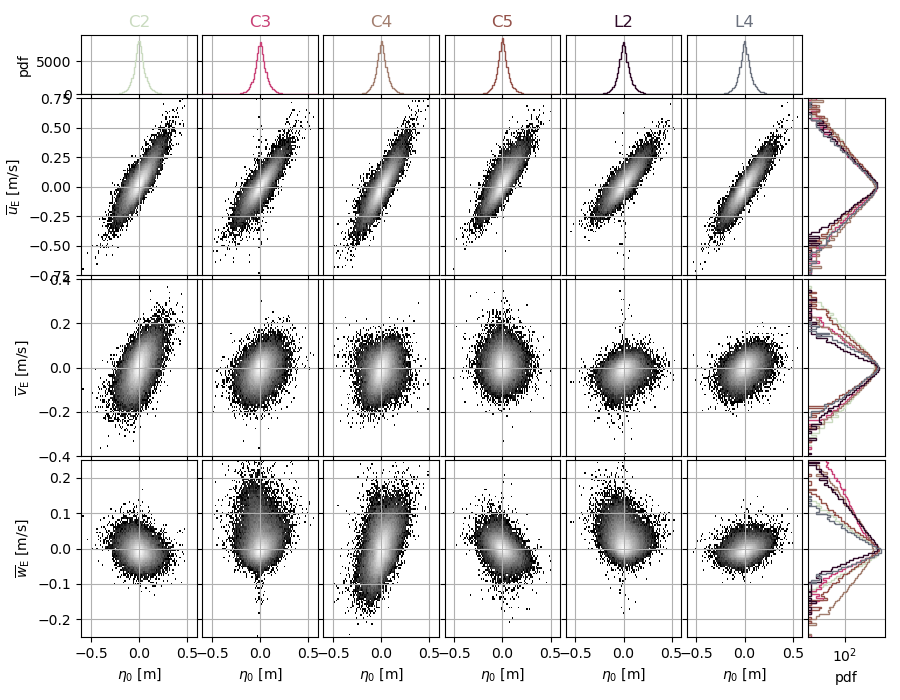

In [52]:
# Plot mean zero-crossing sea level vs. mean zero-crossing C-S velocity
fig, axes = plt.subplots(figsize=(9,7), ncols=7, nrows=4, sharex='col', sharey='row',
    gridspec_kw={'height_ratios': [1, 3, 3, 3], 'width_ratios': [3, 3, 3, 3, 3, 3, 2]})

cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
mids = ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']
for i, mid in enumerate(mids):
    # Get xy axes for cross-shore vel.
    x = dfd[mid].eta_mean.values
    y = dfd[mid].ucs_mean.values
    nanxy = np.logical_or(np.isnan(x), np.isnan(y))
    x = x[~nanxy]
    y = y[~nanxy]
    # 1D histograms of x on top row
    bx = np.linspace(-0.6, 0.6, 100)
    by = np.linspace(-0.75, 0.75, 100)
    # x axis always the same, only plot once
    axes[0, i].hist(x, bins=bx, histtype='step', color=cs[i])
    # Flipped 1D hist of y in last subplot on right
    axes[1,-1].hist(y, bins=by, orientation='horizontal', histtype='step', color=cs[i])
    # Use 2D histogram for scatter plots
    _, xe, ye, im = axes[1,i].hist2d(x, y, norm=colors.LogNorm(), cmap=mpl.cm.gray, 
                                     bins=[bx,by])
    axes[0,i].set_title(mid, color=cs[i])

    # Along-shore velocities
    x = dfd[mid].eta_mean.values
    y = dfd[mid].uls_mean.values
    nanxy = np.logical_or(np.isnan(x), np.isnan(y))
    x = x[~nanxy]
    y = y[~nanxy]
    # 1D histograms of x on top row
    by = np.linspace(-0.4, 0.4, 100)
    # Flipped 1D hist of y in last subplot on right
    axes[2,-1].hist(y, bins=by, orientation='horizontal', histtype='step', color=cs[i])
    # Use 2D histogram for scatter plots
    _, xe, ye, im = axes[2,i].hist2d(x, y, norm=colors.LogNorm(), cmap=mpl.cm.gray, 
                                     bins=[bx,by])

    # Vertical velocities
    x = dfd[mid].eta_mean.values
    y = dfd[mid].w_mean.values
    nanxy = np.logical_or(np.isnan(x), np.isnan(y))
    x = x[~nanxy]
    y = y[~nanxy]
    # 1D histograms of x on top row
    by = np.linspace(-0.25, 0.25, 100)
    # Flipped 1D hist of y in last subplot on right
    axes[3,-1].hist(y, bins=by, orientation='horizontal', histtype='step', color=cs[i])
    # Use 2D histogram for scatter plots
    _, xe, ye, im = axes[3,i].hist2d(x, y, norm=colors.LogNorm(), cmap=mpl.cm.gray, 
                                     bins=[bx,by])
    axes[1,-1].set_xscale('log')
    axes[2,-1].set_xscale('log')
    axes[3,-1].set_xscale('log')

# Labels
for ii,ax in enumerate(axes[-1,:]):
    ax.set_xlabel(r'$\eta_0$ [m]')
    if ii == 6:
        ax.set_xlabel(r'pdf')

axes[0,0].set_ylabel(r'pdf')
axes[1,0].set_ylabel(r'$\overline{u}_\mathrm{E}$ [m/s]')
axes[2,0].set_ylabel(r'$\overline{v}_\mathrm{E}$ [m/s]')
axes[3,0].set_ylabel(r'$\overline{w}_\mathrm{E}$ [m/s]')

for ax in axes.flat:
    ax.grid()

fig.delaxes(axes[0,-1]) # Remove empty upper right corner subplot
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.025)
# Save figure
fn_fig = os.path.join(figdir, 'vec_eta0_vs_vel.pdf')
plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
# plt.show()
plt.close()



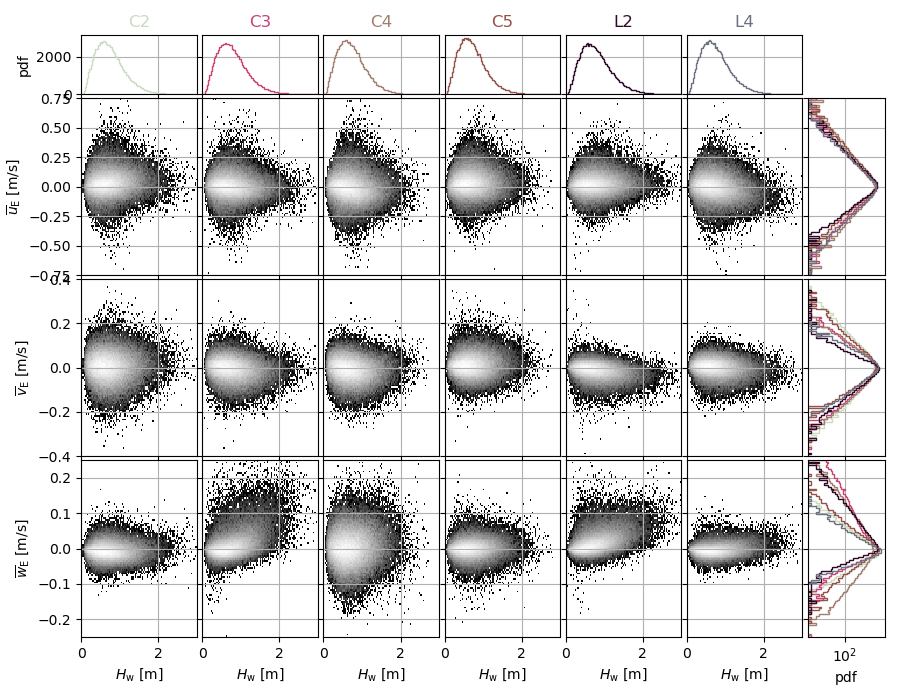

In [53]:
# Plot mean zero-crossing sea level vs. mean zero-crossing C-S velocity
fig, axes = plt.subplots(figsize=(9,7), ncols=7, nrows=4, sharex='col', sharey='row',
    gridspec_kw={'height_ratios': [1, 3, 3, 3], 'width_ratios': [3, 3, 3, 3, 3, 3, 2]})

cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
mids = ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']
for i, mid in enumerate(mids):
    # Get xy axes for cross-shore vel.
    x = dfd[mid].Hw.values
    y = dfd[mid].ucs_mean.values
    nanxy = np.logical_or(np.isnan(x), np.isnan(y))
    x = x[~nanxy]
    y = y[~nanxy]
    # 1D histograms of x on top row
    bx = np.linspace(0, 3, 100)
    by = np.linspace(-0.75, 0.75, 100)
    # x axis always the same, only plot once
    axes[0, i].hist(x, bins=bx, histtype='step', color=cs[i])
    # Flipped 1D hist of y in last subplot on right
    axes[1,-1].hist(y, bins=by, orientation='horizontal', histtype='step', color=cs[i])
    # Use 2D histogram for scatter plots
    _, xe, ye, im = axes[1,i].hist2d(x, y, norm=colors.LogNorm(), cmap=mpl.cm.gray, 
                                     bins=[bx,by])
    axes[0,i].set_title(mid, color=cs[i])

    # Along-shore velocities
    x = dfd[mid].Hw.values
    y = dfd[mid].uls_mean.values
    nanxy = np.logical_or(np.isnan(x), np.isnan(y))
    x = x[~nanxy]
    y = y[~nanxy]
    # 1D histograms of x on top row
    by = np.linspace(-0.4, 0.4, 100)
    # Flipped 1D hist of y in last subplot on right
    axes[2,-1].hist(y, bins=by, orientation='horizontal', histtype='step', color=cs[i])
    # Use 2D histogram for scatter plots
    _, xe, ye, im = axes[2,i].hist2d(x, y, norm=colors.LogNorm(), cmap=mpl.cm.gray, 
                                     bins=[bx,by])

    # Vertical velocities
    x = dfd[mid].Hw.values
    y = dfd[mid].w_mean.values
    nanxy = np.logical_or(np.isnan(x), np.isnan(y))
    x = x[~nanxy]
    y = y[~nanxy]
    # 1D histograms of x on top row
    by = np.linspace(-0.25, 0.25, 100)
    # Flipped 1D hist of y in last subplot on right
    axes[3,-1].hist(y, bins=by, orientation='horizontal', histtype='step', color=cs[i])
    # Use 2D histogram for scatter plots
    _, xe, ye, im = axes[3,i].hist2d(x, y, norm=colors.LogNorm(), cmap=mpl.cm.gray, 
                                     bins=[bx,by])
    axes[1,-1].set_xscale('log')
    axes[2,-1].set_xscale('log')
    axes[3,-1].set_xscale('log')

# Labels
for ii,ax in enumerate(axes[-1,:]):
    ax.set_xlabel(r'$H_\mathrm{w}$ [m]')
    if ii == 6:
        ax.set_xlabel(r'pdf')

axes[0,0].set_ylabel(r'pdf')
axes[1,0].set_ylabel(r'$\overline{u}_\mathrm{E}$ [m/s]')
axes[2,0].set_ylabel(r'$\overline{v}_\mathrm{E}$ [m/s]')
axes[3,0].set_ylabel(r'$\overline{w}_\mathrm{E}$ [m/s]')

for ax in axes.flat:
    ax.grid()

fig.delaxes(axes[0,-1]) # Remove empty upper right corner subplot
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.025)
plt.show()


[False False False False  True  True False False False  True]


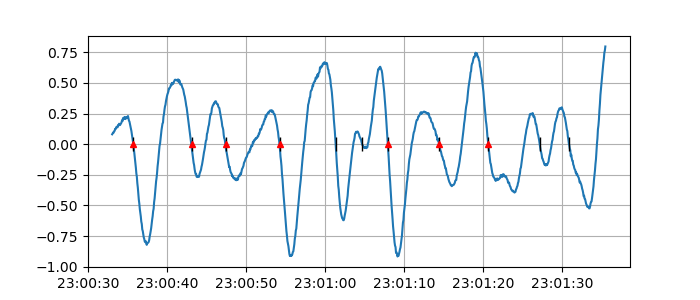

In [13]:
idx = np.argwhere(dfd['L2'].ucs_mean.values == dfd['L2'].ucs_mean.max()).item()
dfd['L2'].iloc[idx]
# dfd['L2'].eta_mean.max()
np.diff(zc).shape
# (np.diff(zc) / 16).min()
ep = eta.iloc[:1000].copy()
zci, _, _, _ = rpzc.get_waveheights(ep)
idx = (np.diff(zci[::1]) / 16) < 4
print(idx)
zci2 = zci[:-1][~idx]
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(ep.index, ep)
ax.grid()
ax.plot(ep.index[zci], np.zeros_like(ep)[zci], linestyle='none', marker='|',
    color='k', markersize=10)
ax.plot(ep.index[zci2], np.zeros_like(ep)[zci2], linestyle='none', marker='^',
    color='r', markersize=5)

plt.show()


Plot mean velocity time series for each ADV.

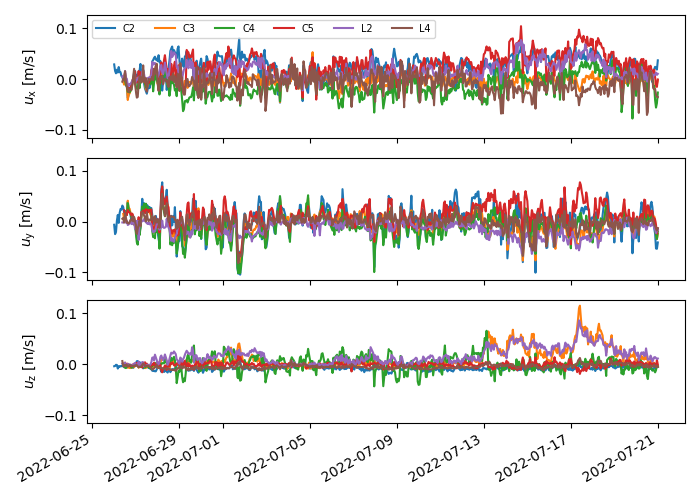

In [5]:
# Plot time series of all mean velocities
t0 = pd.Timestamp('2022-06-26 00:00:00')
t1 = pd.Timestamp('2022-07-21 00:00:00')
fig, axes = plt.subplots(figsize=(7,5), nrows=3, sharex=True, sharey=True)
for i, mid in enumerate(mids):
    vecd[mid].ucs.sel(time=slice(t0,t1)).interpolate_na(dim='time').plot(ax=axes[0], label=mid)
    axes[0].set_ylabel(r'$u_\mathrm{x}$ [m/s]')
    axes[0].set_title('20-min mean Vector velocities')
    axes[0].legend(ncols=6, fontsize=7)
    vecd[mid].uls.sel(time=slice(t0,t1)).interpolate_na(dim='time').plot(ax=axes[1], label=mid)
    axes[1].set_ylabel(r'$u_\mathrm{y}$ [m/s]')
    vecd[mid].uU.sel(time=slice(t0,t1)).interpolate_na(dim='time').plot(ax=axes[2], label=mid)
    axes[2].set_ylabel(r'$u_\mathrm{z}$ [m/s]')

for ax in axes:
    ax.set_xlabel(None)

plt.tight_layout()
plt.show()

Plot time series of std of velocities.

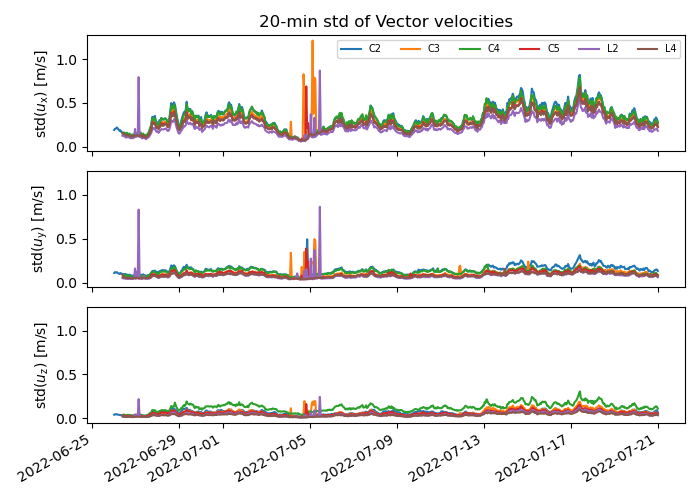

In [7]:
# Plot time series of all std velocities
t0 = pd.Timestamp('2022-06-26 00:00:00')
t1 = pd.Timestamp('2022-07-21 00:00:00')
fig, axes = plt.subplots(figsize=(7,5), nrows=3, sharex=True, sharey=True)
for i, mid in enumerate(mids):
    vecsd[mid].ucs.sel(time=slice(t0,t1)).interpolate_na(dim='time').plot(ax=axes[0], label=mid)
    axes[0].set_ylabel(r'$\mathrm{std}(u_\mathrm{x})$ [m/s]')
    axes[0].set_title('20-min std of Vector velocities')
    axes[0].legend(ncols=6, fontsize=7)
    vecsd[mid].uls.sel(time=slice(t0,t1)).interpolate_na(dim='time').plot(ax=axes[1], label=mid)
    axes[1].set_ylabel(r'$\mathrm{std}(u_\mathrm{y})$ [m/s]')
    vecsd[mid].uU.sel(time=slice(t0,t1)).interpolate_na(dim='time').plot(ax=axes[2], label=mid)
    axes[2].set_ylabel(r'$\mathrm{std}(u_\mathrm{z})$ [m/s]')

for ax in axes:
    ax.set_xlabel(None)

plt.tight_layout()
plt.show()

Investigate individual high-frequency signals.

C2 - 17212
file:  Asilomar_SSA_L1_Vec_17212.nc
C3 - 17219
file:  Asilomar_SSA_L1_Vec_17219.nc
C4 - 17371
file:  Asilomar_SSA_L1_Vec_17371.nc


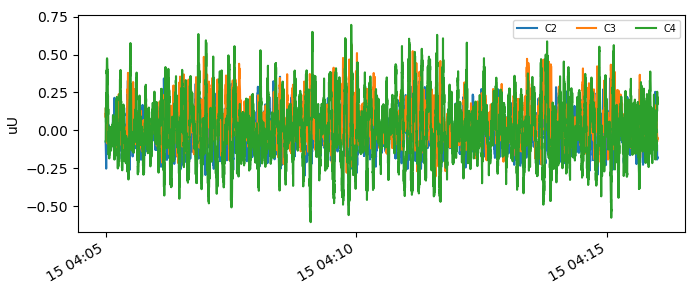

In [36]:
# List available serial numbers and mooring IDs
servs = ['17212', '17219', '17371', '17372', '17376', '17377'] # Serial #s of Vectors
mids = [ 'C2',    'C3',    'C4',    'C5',    'L2',    'L4'] # Mooring IDs

# Select mooring ID(s) and time period to focus on
mids_focus = ['C2', 'C3', 'C4']
# Get corresponding serial numbers
inds = np.array([np.argwhere(np.array(mids) == m) for m in mids_focus]).squeeze()
sers_focus = np.array(servs)[inds]
# Focus time period
t0 = pd.Timestamp('2022-07-15 04:05:00')
t1 = pd.Timestamp('2022-07-15 04:16:00')
# Variable to plot
key = 'uU'

# Initialize figure
fig, ax = plt.subplots(figsize=(7,3))
# Iterate over mooring ID(s) and plot
for mid, ser in zip(mids_focus, sers_focus):
    print('{} - {}'.format(mid, ser))
    fn_vec = [f for f in fns_vec if ser in f]
    print('file: ', os.path.split(fn_vec[0])[1])
    dsv = xr.decode_cf(xr.open_dataset(fn_vec[0], decode_coords='all'))
    dsv = dsv.sel(time=slice(t0, t1))

    # Convert despiked xyz velocities to ENU
    enu = rpct.uvw2enu(vel=np.array([dsv.uxd.values, dsv.uyd.values, dsv.uzd.values]).T, 
        heading=dsv.heading_ang.values, pitch=dsv.pitch_ang.values,
        roll=dsv.roll_ang.values, magdec=12.86)

    # Save variables to dataset
    dsv['uE'] = (['time'], enu[0,:].copy())
    dsv['uN'] = (['time'], enu[1,:].copy())
    dsv['uU'] = (['time'], enu[2,:].copy())

    # Convert E,N velocities to local cross- & alongshore (x,y) components
    angle_met = 300
    angle_math = 270 - angle_met
    if angle_math < 0:
        angle_math += 360
    angle_math = np.deg2rad(angle_math)
    ur, vr = rpct.rotate_vel(dsv['uE'].values, dsv['uN'].values, angle_math)
    dsv['ucs'] = (['time'], ur)
    dsv['uls'] = (['time'], vr)
    
    # Plot requested variable
    # dsv['uz'].plot(ax=ax, label='{}-raw'.format(mid))
    dsv[key].plot(ax=ax, label='{}'.format(mid))
    ax.set_xlabel(None)
    ax.legend(ncols=len(mids_focus), fontsize=7)

plt.tight_layout()
plt.show()



In [39]:
dsv.pressure

<xarray.DataArray 'pressure' (time: 10560)>
[10560 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2022-07-15T04:05:00.031250 ... 2022-07-15T...
Attributes:
    units:          hPa
    standard_name:  sea_water_pressure_due_to_sea_water
    long_name:      Hydrostatic pressure recorded by instrument